In [4]:
# Employee Turnover Prediction ML Pipeline for Portobello Tech
# Complete solution covering data quality, EDA, clustering, SMOTE, and model evaluation

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score,\
f1_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE


#=====All Packages=======

In [4]:
#Load Data and do the EDA

df = pd.read_csv("HR_comma_sep.csv")
df.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years  sales  \
0                   3              0     1                      0  sales   
1                   6              0     1                      0  sales   
2                   4              0     1                      0  sales   
3                   5              0     1                      0  sales   
4                   3              0     1                      0  sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [6]:
df.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

In [7]:
# check any missing data

df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [8]:
# As result, no missing data


3008

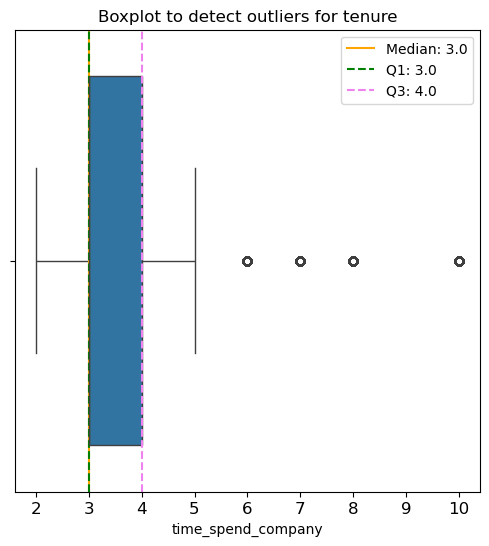

In [14]:
# Create a boxplot to visualize distribution of time_spend_company and detect any outliers

percentile25 = df['time_spend_company'].quantile(0.25)
percentile75 = df['time_spend_company'].quantile(0.75)
median_value = df['time_spend_company'].median()

plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['time_spend_company'])

plt.axvline(median_value, color='orange', linestyle='-', label=f'Median: {median_value}')
plt.axvline(percentile25, color='green', linestyle='--', label=f'Q1: {percentile25}')
plt.axvline(percentile75, color='violet', linestyle='--', label=f'Q3: {percentile75}')

plt.legend()
plt.show()

In [17]:
# Check number of rows with outliers 

# Compute the 25th percentile value in `time_spend_company`
percentile25 = df['time_spend_company'].quantile(0.25)

# Compute the 75th percentile value in `time_spend_company`
percentile75 = df['time_spend_company'].quantile(0.75)

# Compute the interquartile range in `time_spend_company`
iqr = percentile75 - percentile25

# Define the upper limit and lower limit for non-outlier values in `time_spend_company`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `time_spend_company`
outliers = df[(df['time_spend_company'] > upper_limit) | (df['time_spend_company'] < lower_limit)]

# Count how many rows in the data contain outliers in `tenure`
print("Number of rows in the data containing outliers in `time_spend_company`:", len(outliers))

outliers.head()

outliers_left= outliers[(outliers['left']==True) & (outliers['salary']=='low')]
len(outliers_left)

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `time_spend_company`: 1282


135

C:\Users\KaruneshChoudhary\AppData\Local\Temp\ipykernel_14184\1560487106.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


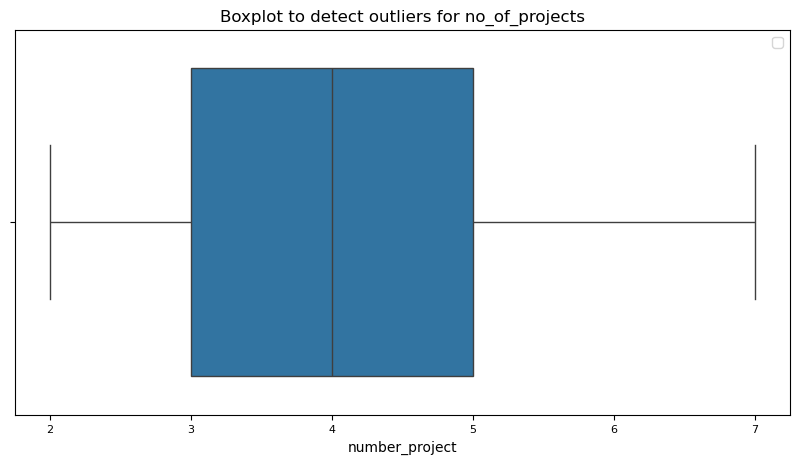

In [19]:
# Create a boxplot to visualize distribution of `number_project` and detect any outliers
plt.figure(figsize=(10,5))
plt.title('Boxplot to detect outliers for no_of_projects', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
sns.boxplot(x=df['number_project'])

plt.legend()
plt.show()

In [ ]:
# no outliers

In [21]:
# Get numbers of people who left vs. stayed
print(df['left'].value_counts())
print()

# Get percentages of people who left vs. stayed
print(df['left'].value_counts(normalize=True))

left
0    11428
1     3571
Name: count, dtype: int64

left
0    0.761917
1    0.238083
Name: proportion, dtype: float64


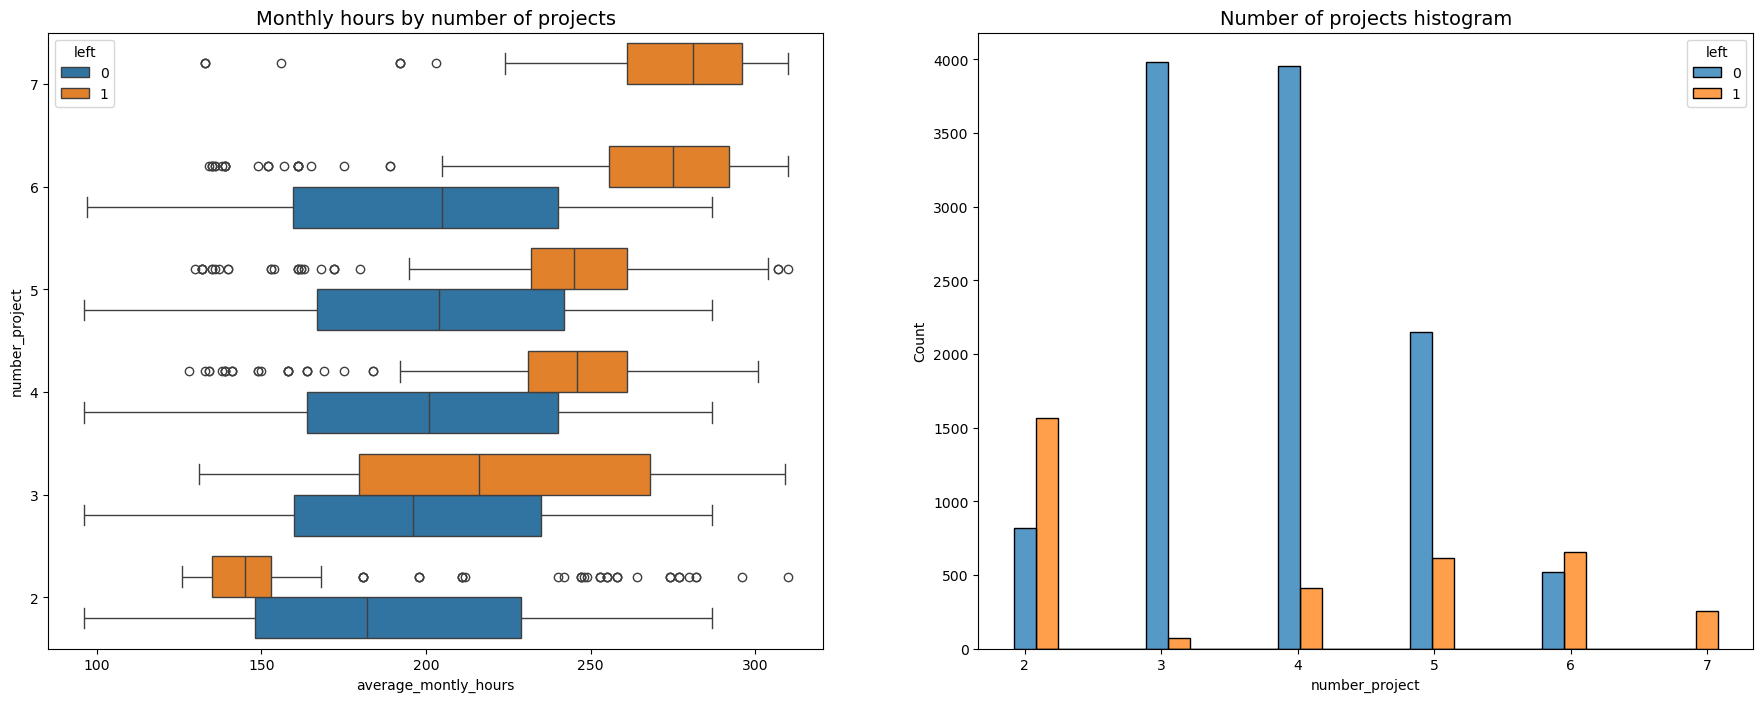

In [23]:
# Create plot, Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing `average_montly_hours` distributions for `number_project`, comparing employees who stayed versus those who left
sns.boxplot(data=df, x='average_montly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

# Create histogram showing distribution of `number_project`, comparing employees who stayed versus those who left
tenure_stay = df[df['left']==0]['number_project']
tenure_left = df[df['left']==1]['number_project']
sns.histplot(data=df, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

# Display the plots
plt.show()

In [ ]:
# It shows more working hrs lead employee leaving the company, also there is a case where less projects and less hrs work also left the company (may be fired)

In [25]:
df[df['number_project']==7]['left'].value_counts()

left
1    256
Name: count, dtype: int64

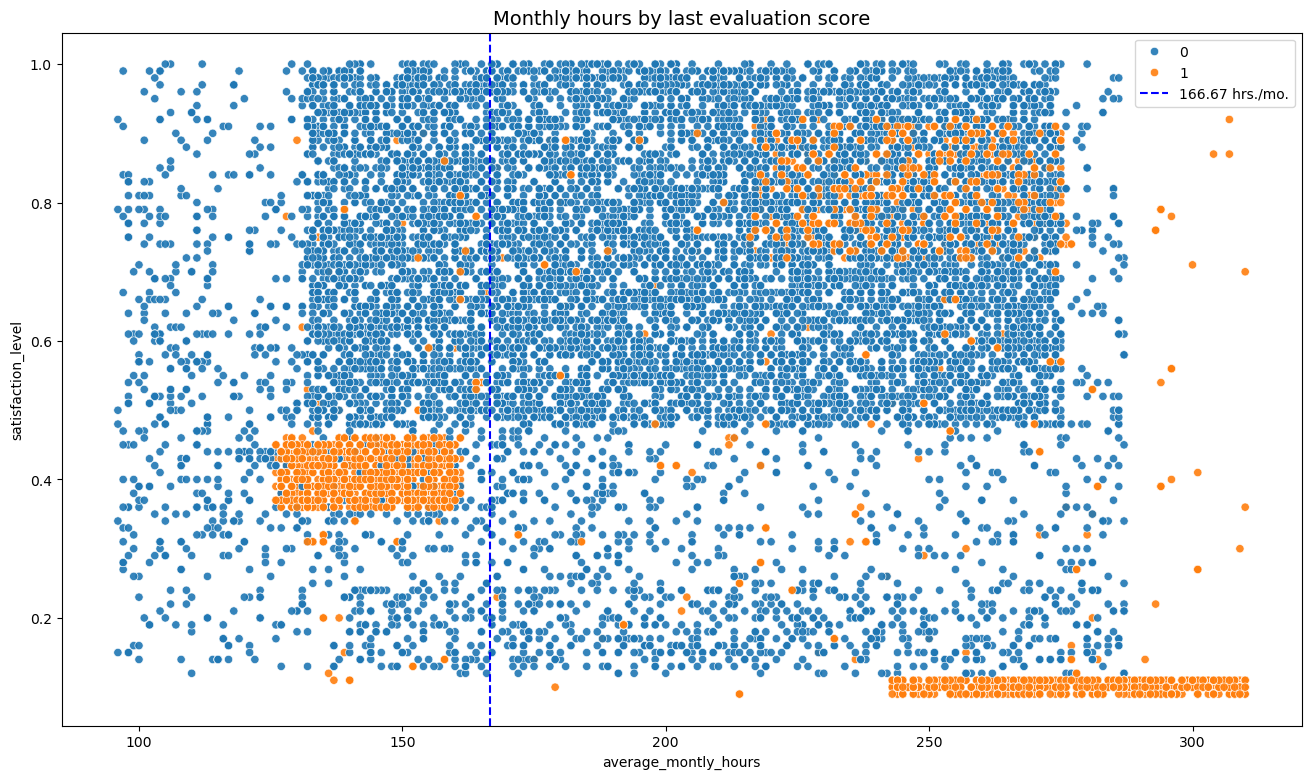

In [26]:
# Create scatterplot of `average_montly_hours` versus `satisfaction_level`, comparing employees who stayed versus those who left
# average number of working hours per month of employees working Monday–Friday = 50 weeks * 40 hours per week / 12 months = 166.67 hours per month.
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='average_montly_hours', y='satisfaction_level', hue='left', alpha=0.9)
plt.axvline(x=166.67, color='b', label='166.67 hrs./mo.', ls='--')
# plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])....this only works in jupyter notebook
plt.legend()
plt.title('Monthly hours by last evaluation score', fontsize='14');

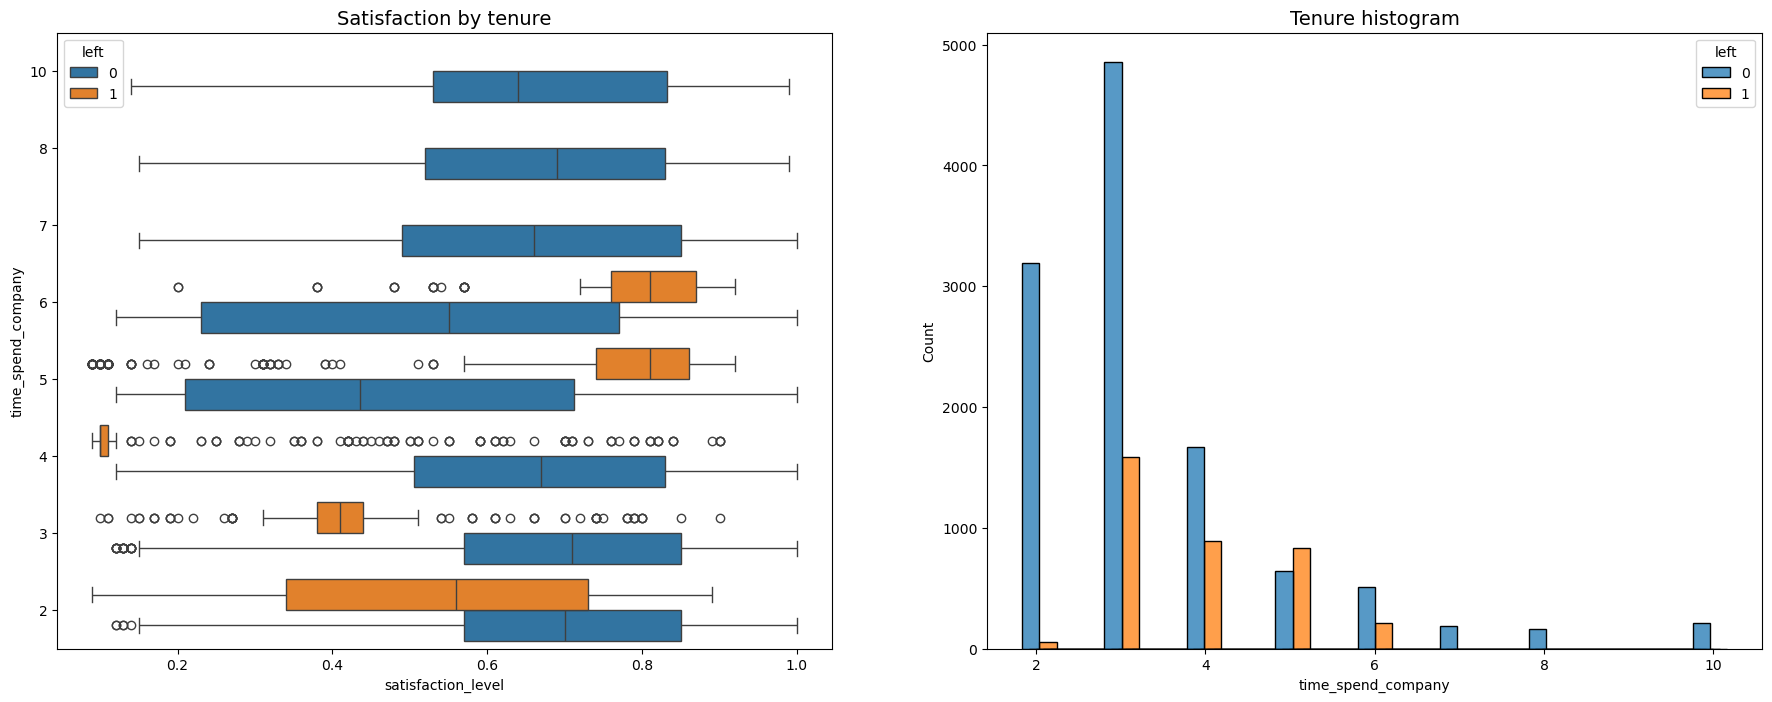

In [27]:


# Create boxplot showing distributions of `satisfaction_level` by time_spend_company, comparing employees who stayed versus those who left
fig, ax = plt.subplots(1, 2, figsize = (22,8))
sns.boxplot(data=df, x='satisfaction_level', y='time_spend_company', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

# Create histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
tenure_stay = df[df['left']==0]['time_spend_company']
tenure_left = df[df['left']==1]['time_spend_company']
sns.histplot(data=df, x='time_spend_company', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

In [28]:
# Calculate mean and median satisfaction scores of employees who left and those who stayed
df.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

C:\Users\KaruneshChoudhary\AppData\Local\Temp\ipykernel_14184\2798253750.py:2: FutureWarning: The provided callable <function mean at 0x0000013A83A30220> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])
C:\Users\KaruneshChoudhary\AppData\Local\Temp\ipykernel_14184\2798253750.py:2: FutureWarning: The provided callable <function median at 0x0000013A83BA3B00> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])


mean  median
left                  
0     0.666810    0.69
1     0.440098    0.41

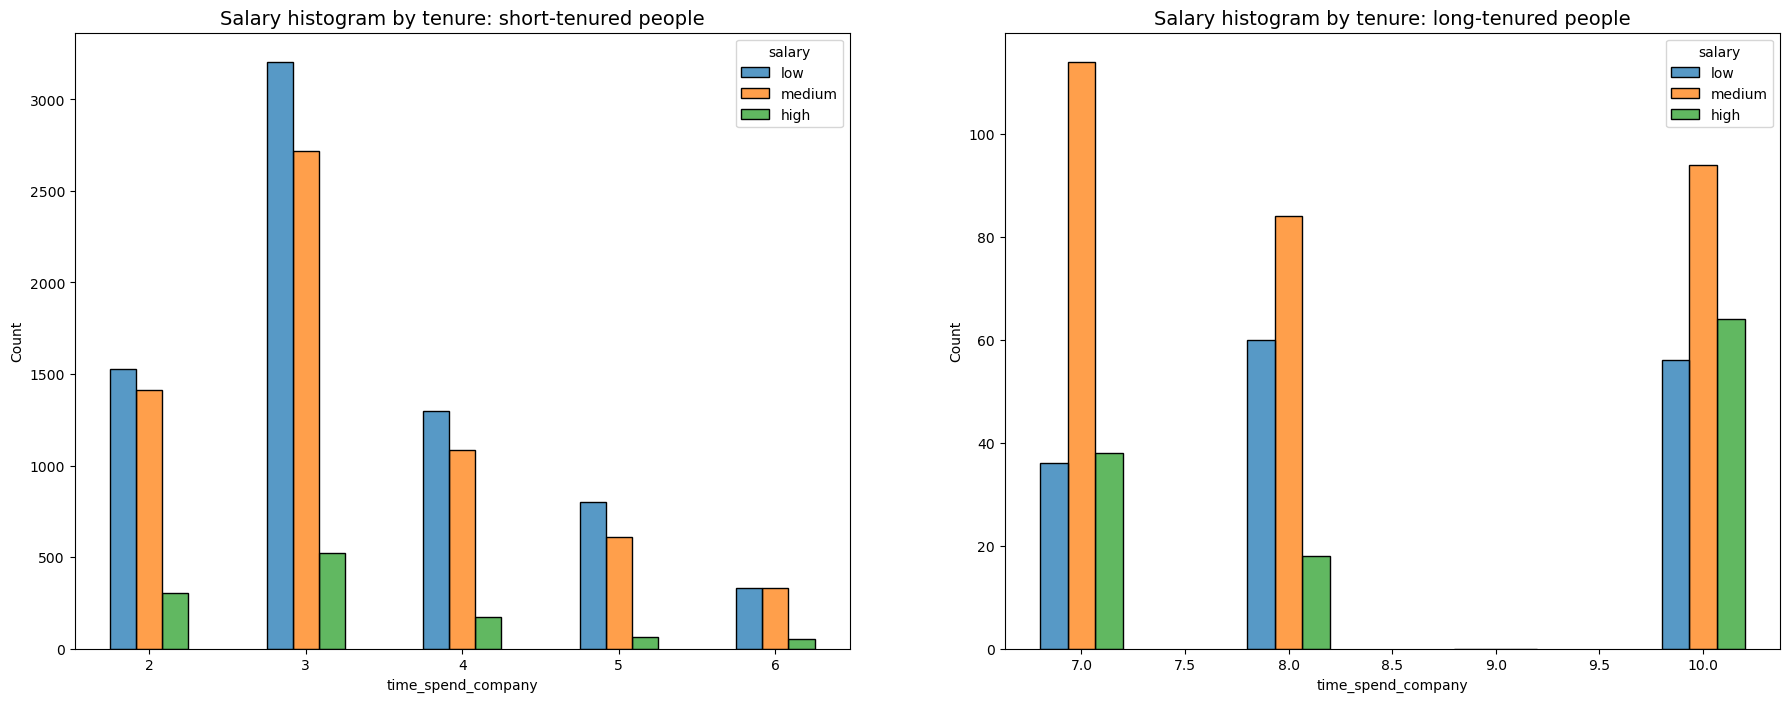

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Define short-tenured employees
tenure_short = df[df['time_spend_company'] < 7]

# Define long-tenured employees
tenure_long = df[df['time_spend_company'] > 6]

# Plot short-tenured histogram
sns.histplot(data=tenure_short, x='time_spend_company', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

# Plot long-tenured histogram
sns.histplot(data=tenure_long, x='time_spend_company', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

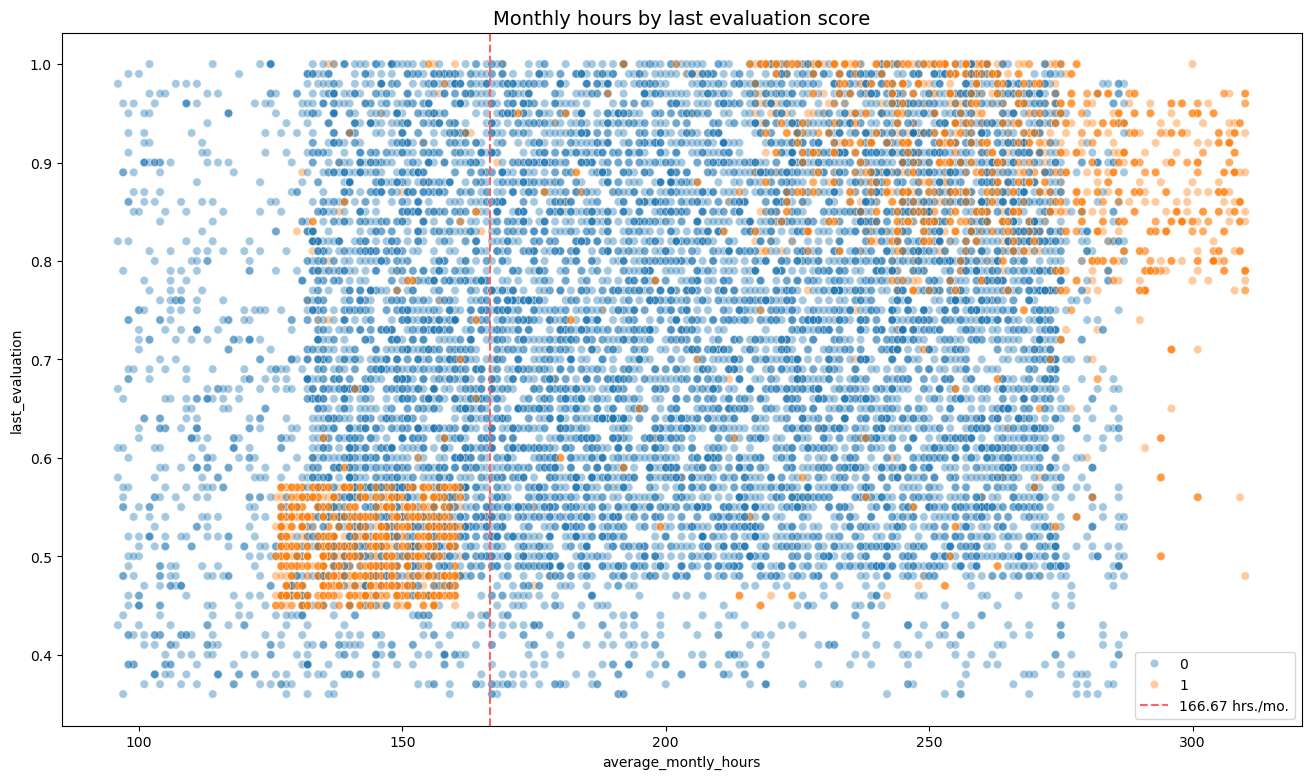

In [31]:
# Create scatterplot of `average_monthly_hours` versus `last_evaluation`
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='average_montly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend()
plt.title('Monthly hours by last evaluation score', fontsize='14');

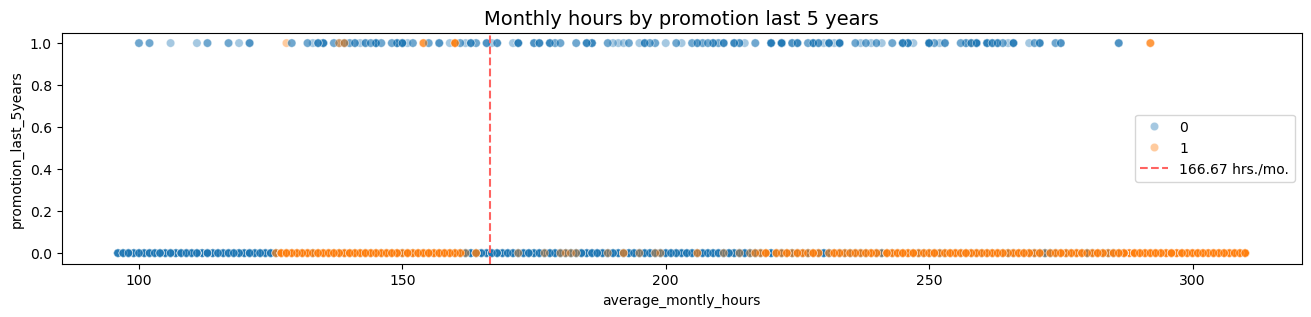

In [33]:
# Create plot to examine relationship between `average_monthly_hours` and `promotion_last_5years`
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df, x='average_montly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--', label='166.67 hrs./mo.')
plt.legend()
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

In [36]:
df["sales"].value_counts()

sales
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: count, dtype: int64

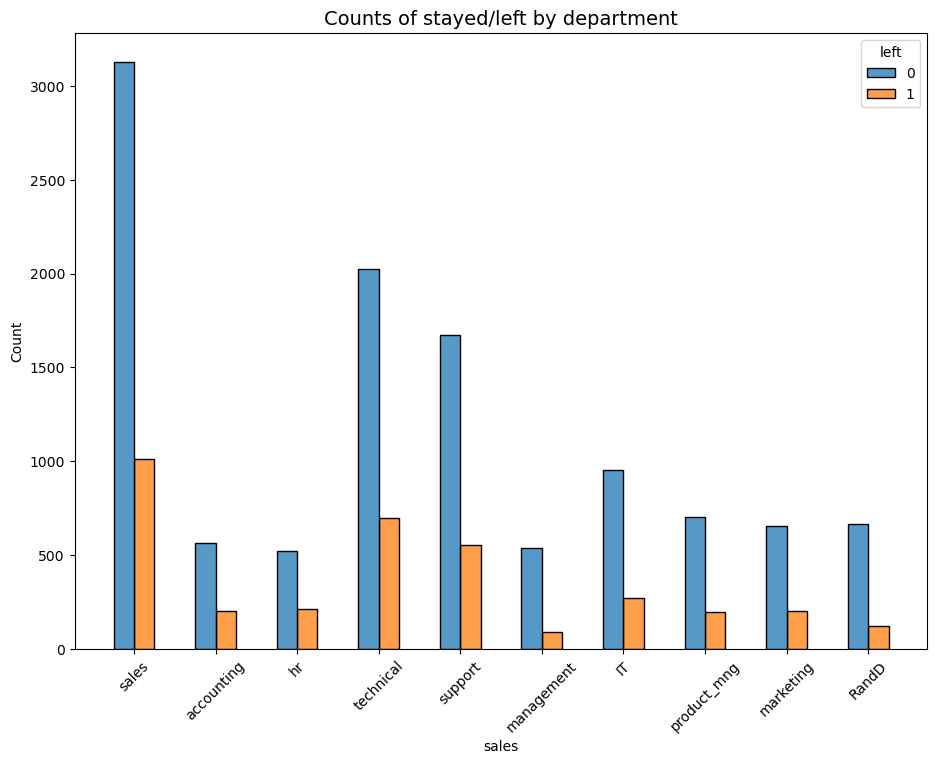

In [37]:
# Create stacked histogram to compare department(sales) distribution of employees who left to that of employees who didn't
plt.figure(figsize=(11,8))
sns.histplot(data=df, x='sales', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of stayed/left by department', fontsize=14);

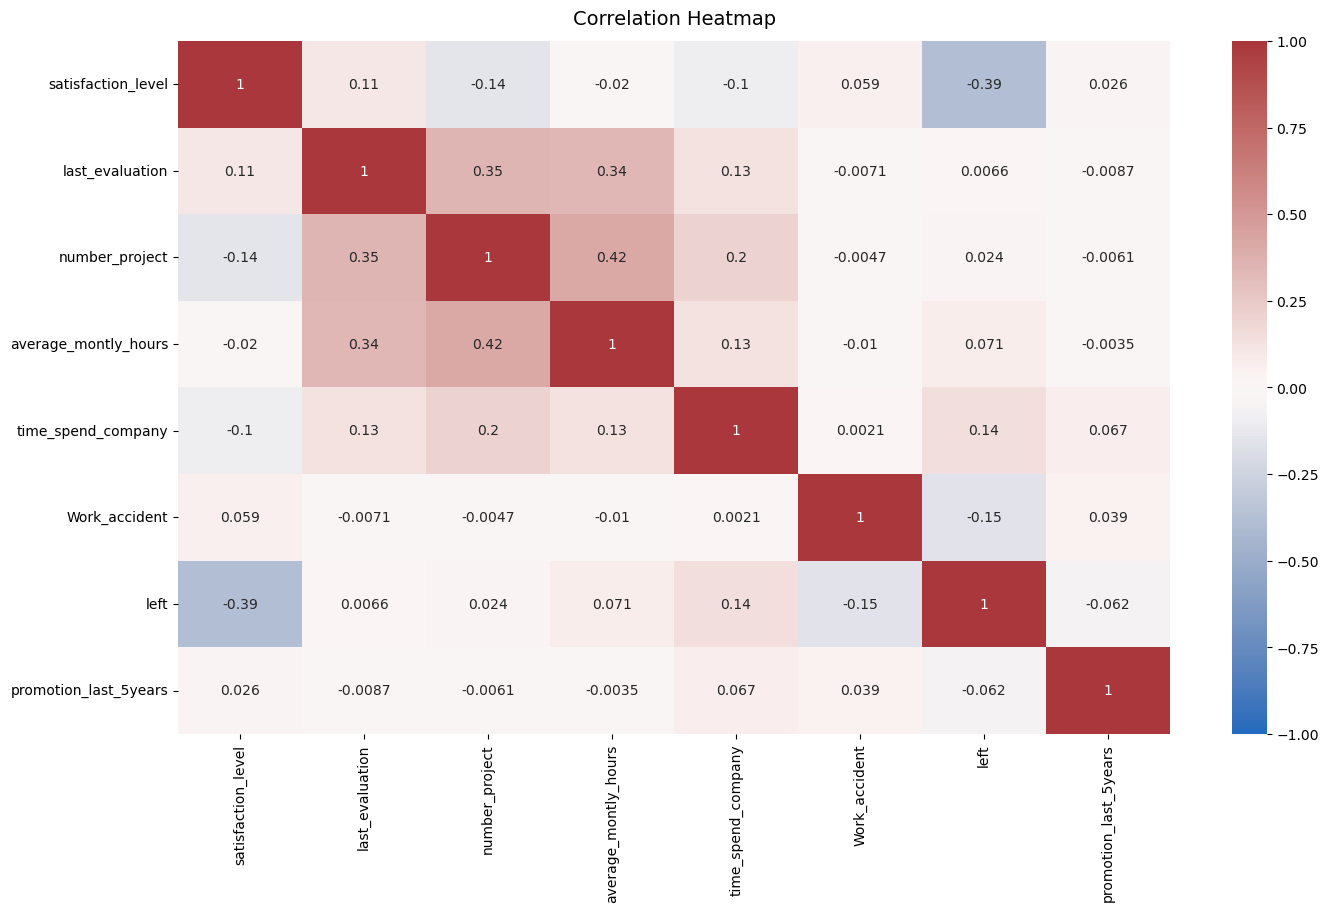

In [40]:
# Plot a correlation heatmap
plt.figure(figsize=(16, 9))
df_numeric = df.drop(columns=['sales', 'salary'])
heatmap = sns.heatmap(df_numeric.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

   __This text will also appear bold.__

In [41]:
# Copy the dataframe to perform Modeling
df_enc = df.copy()

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)
# Dummy encode the `sales` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display the new dataframe
df_enc.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years  salary  \
0                   3              0     1                      0       0   
1                   6              0     1                      0       1   
2                   4              0     1                      0       1   
3                   5              0     1                      0       0   
4                   3              0     1                      0       0   

   sales_IT  sales_RandD  sales_accounting  sales_hr  sales_management  \
0     False        False             False     False             False   
1     False        False             False     False             False   
2     False        False             False     False             False   
3     False        False             False     False             False   
4     False        False             False     False             False   

   sales_marketing  sales_product_mng  sales_sales  sales_support  \
0            False              False         True          False   
1            False              False         True          False   
2            False              False         True          False   
3            False              False         True          False   
4            False              False         True          False   

   sales_technical  
0            False  
1            False  
2            False  
3            False  
4            False

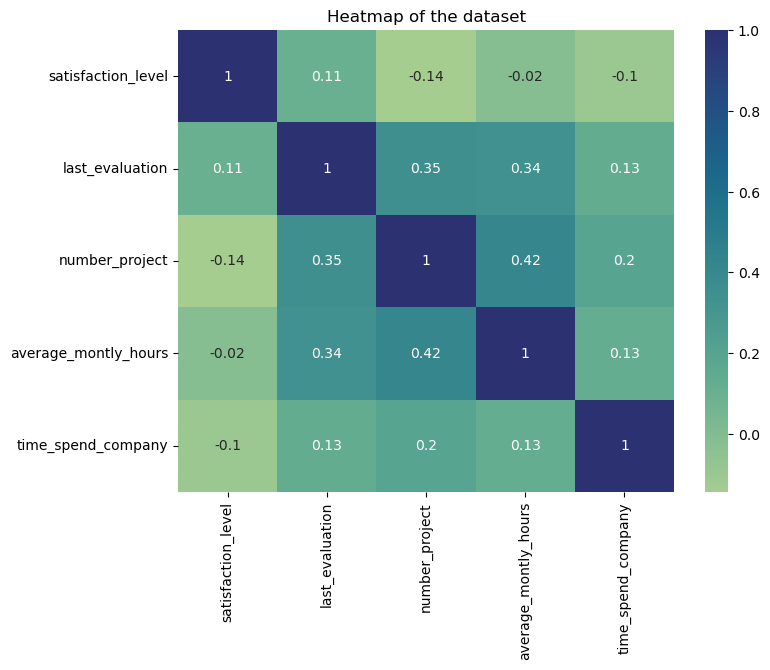

In [42]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

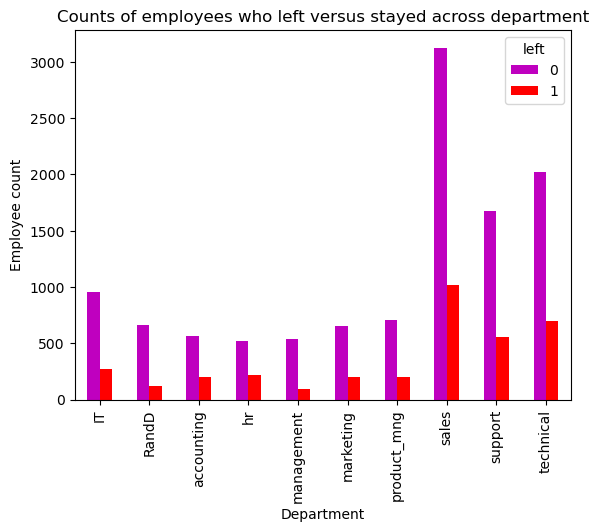

In [43]:
# Create a stacked bar plot to visualize number of employees across department, comparing those who left with those who didn't
# In the legend, 0 (purple color) represents employees who did not leave, 1 (red color) represents employees who left
pd.crosstab(df['sales'], df['left']).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

In [44]:
# Select rows without outliers in `time_spend_company` and save resulting dataframe in a new variable
df_logreg = df_enc[(df_enc['time_spend_company'] >= lower_limit) & (df_enc['time_spend_company'] <= upper_limit)]
df_logreg.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   
5                0.41             0.50               2                   153   

   time_spend_company  Work_accident  left  promotion_last_5years  salary  \
0                   3              0     1                      0       0   
2                   4              0     1                      0       1   
3                   5              0     1                      0       0   
4                   3              0     1                      0       0   
5                   3              0     1                      0       0   

   sales_IT  sales_RandD  sales_accounting  sales_hr  sales_management  \
0     False        False             False     False             False   
2     False        False             False     False             False   
3     False        False             False     False             False   
4     False        False             False     False             False   
5     False        False             False     False             False   

   sales_marketing  sales_product_mng  sales_sales  sales_support  \
0            False              False         True          False   
2            False              False         True          False   
3            False              False         True          False   
4            False              False         True          False   
5            False              False         True          False   

   sales_technical  
0            False  
2            False  
3            False  
4            False  
5            False

In [45]:
y = df_logreg['left']
y.head() 

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [46]:
X = df_logreg.drop('left', axis=1)
X.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   
5                0.41             0.50               2                   153   

   time_spend_company  Work_accident  promotion_last_5years  salary  sales_IT  \
0                   3              0                      0       0     False   
2                   4              0                      0       1     False   
3                   5              0                      0       0     False   
4                   3              0                      0       0     False   
5                   3              0                      0       0     False   

   sales_RandD  sales_accounting  sales_hr  sales_management  sales_marketing  \
0        False             False     False             False            False   
2        False             False     False             False            False   
3        False             False     False             False            False   
4        False             False     False             False            False   
5        False             False     False             False            False   

   sales_product_mng  sales_sales  sales_support  sales_technical  
0              False         True          False            False  
2              False         True          False            False  
3              False         True          False            False  
4              False         True          False            False  
5              False         True          False            False

In [47]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [48]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

In [49]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

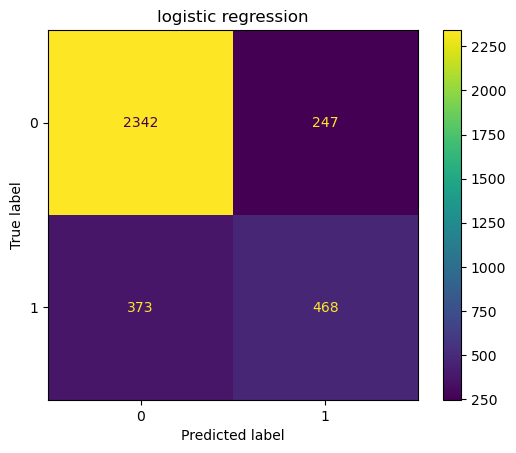

In [52]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)
# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)
# Plot confusion matrix
log_disp.plot(values_format='')

# Add title to the confusion matrix plot
plt.title('logistic regression')

# Display plot
plt.show()

In [53]:
df_logreg['left'].value_counts(normalize=True)

left
0    0.754903
1    0.245097
Name: proportion, dtype: float64

In [54]:
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.90      0.88      2589
    Predicted would leave       0.65      0.56      0.60       841

                 accuracy                           0.82      3430
                macro avg       0.76      0.73      0.74      3430
             weighted avg       0.81      0.82      0.81      3430



__Tree-based Model__

In [62]:
# Drop the outcome variable
y = df_enc['left']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [63]:
# Select the features
X = df_enc.drop('left', axis=1)

# Display the first few rows of `X`
X.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  promotion_last_5years  salary  sales_IT  \
0                   3              0                      0       0     False   
1                   6              0                      0       1     False   
2                   4              0                      0       1     False   
3                   5              0                      0       0     False   
4                   3              0                      0       0     False   

   sales_RandD  sales_accounting  sales_hr  sales_management  sales_marketing  \
0        False             False     False             False            False   
1        False             False     False             False            False   
2        False             False     False             False            False   
3        False             False     False             False            False   
4        False             False     False             False            False   

   sales_product_mng  sales_sales  sales_support  sales_technical  
0              False         True          False            False  
1              False         True          False            False  
2              False         True          False            False  
3              False         True          False            False  
4              False         True          False            False

In [66]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [72]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [73]:
tree1.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [74]:
# Check best parameters
tree1.best_params_


{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [75]:
# Check best AUC score on CV
tree1.best_score_

0.9811399942559518

In [76]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [77]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

model  precision    recall        F1  accuracy      auc
0  decision tree cv    0.96232  0.930913  0.946284  0.974842  0.98114

__Tree-based Model__

In [78]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [79]:
%%time
rf1.fit(X_train, y_train) 

CPU times: total: 24min 54s
Wall time: 26min 9s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [85]:
# Define a path to the folder where you want to save the model
path = 'EmployeeLeavePrediction'

In [86]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [87]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [88]:
# Write pickle
write_pickle(path, rf1, 'hr_rf1')

In [89]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1')

In [90]:
# Check best AUC score on CV
rf1.best_score_

0.9907972854154319

In [91]:
# Check best params
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [95]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy      auc
0  decision tree cv    0.96232  0.930913  0.946284  0.974842  0.98114
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.990386  0.920834  0.954322   0.97902  0.990797


In [96]:
# Define a function that gets all the scores from a model's predictions.
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

In [97]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

model  precision    recall        f1  accuracy       AUC
0  random forest1 test   0.995204  0.929451  0.961204  0.982133  0.964026

__Feature Engineering__

In [98]:
# Drop `satisfaction_level` and save resulting dataframe in new variable
df2 = df_enc.drop('satisfaction_level', axis=1)

# Display first few rows of new dataframe
df2.head()

last_evaluation  number_project  average_montly_hours  time_spend_company  \
0             0.53               2                   157                   3   
1             0.86               5                   262                   6   
2             0.88               7                   272                   4   
3             0.87               5                   223                   5   
4             0.52               2                   159                   3   

   Work_accident  left  promotion_last_5years  salary  sales_IT  sales_RandD  \
0              0     1                      0       0     False        False   
1              0     1                      0       1     False        False   
2              0     1                      0       1     False        False   
3              0     1                      0       0     False        False   
4              0     1                      0       0     False        False   

   sales_accounting  sales_hr  sales_management  sales_marketing  \
0             False     False             False            False   
1             False     False             False            False   
2             False     False             False            False   
3             False     False             False            False   
4             False     False             False            False   

   sales_product_mng  sales_sales  sales_support  sales_technical  
0              False         True          False            False  
1              False         True          False            False  
2              False         True          False            False  
3              False         True          False            False  
4              False         True          False            False

In [100]:
# Create `overworked` column. For now, it's identical to average monthly hours.
df2['overworked'] = df2['average_montly_hours']

# Inspect max and min average monthly hours values
print('Max hours:', df2['overworked'].max())
print('Min hours:', df2['overworked'].min())

Max hours: 310
Min hours: 96


In [101]:
df2['overworked'] = (df2['overworked'] > 175).astype(int)
df2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int32

In [102]:
# Drop the `average_montly_hours` column
df2 = df2.drop('average_montly_hours', axis=1)
# Display first few rows of resulting dataframe
df2.head()

last_evaluation  number_project  time_spend_company  Work_accident  left  \
0             0.53               2                   3              0     1   
1             0.86               5                   6              0     1   
2             0.88               7                   4              0     1   
3             0.87               5                   5              0     1   
4             0.52               2                   3              0     1   

   promotion_last_5years  salary  sales_IT  sales_RandD  sales_accounting  \
0                      0       0     False        False             False   
1                      0       1     False        False             False   
2                      0       1     False        False             False   
3                      0       0     False        False             False   
4                      0       0     False        False             False   

   sales_hr  sales_management  sales_marketing  sales_product_mng  \
0     False             False            False              False   
1     False             False            False              False   
2     False             False            False              False   
3     False             False            False              False   
4     False             False            False              False   

   sales_sales  sales_support  sales_technical  overworked  
0         True          False            False           0  
1         True          False            False           1  
2         True          False            False           1  
3         True          False            False           1  
4         True          False            False           0

In [103]:
# drop left column
Y = df2['left']
# Select the features
X = df2.drop('left', axis=1)

In [105]:
# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

__Decision tree - After feature engineering__

In [106]:
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [108]:
tree2.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [109]:
tree2.best_params_

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [110]:
tree2.best_score_

0.9707127603293837

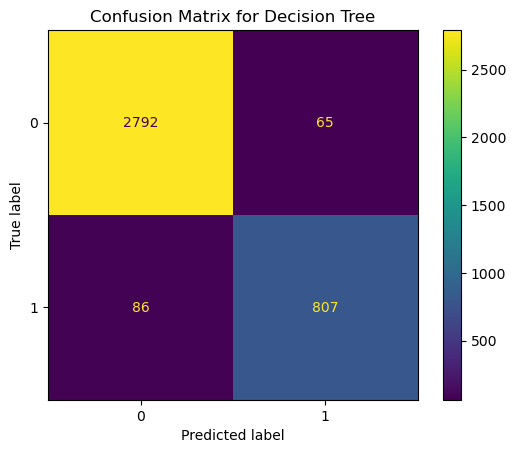

In [111]:
# Generate confusion matrix
preds = tree2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=tree2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=tree2.classes_)
disp.plot(values_format='');
# Add title to the confusion matrix plot
plt.title('Confusion Matrix for Decision Tree')
plt.show()

In [112]:
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy      auc
0  decision tree cv    0.96232  0.930913  0.946284  0.974842  0.98114
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv    0.91728  0.891332  0.904003   0.95493  0.970713


__Random forest - After feature engineering__

In [113]:
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [114]:
%%time
rf2.fit(X_train, y_train)

CPU times: total: 18min 34s
Wall time: 19min 32s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [115]:
write_pickle(path, rf2, 'hr_rf2')

In [121]:
rf2 = read_pickle(path, 'hr_rf2')

In [122]:
rf2.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [123]:
rf2.best_score_

0.9800155462940825

In [124]:
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv    0.91728  0.891332  0.904003   0.95493  0.970713
               model  precision    recall        F1  accuracy       auc
0  random forest2 cv   0.933895  0.907015  0.920104  0.962486  0.980016


In [125]:
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

model  precision    recall        f1  accuracy       AUC
0  random forest2 test   0.933258  0.923852  0.928531  0.966133  0.951601

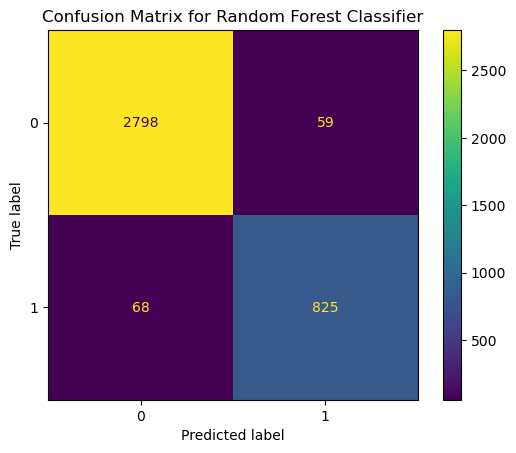

In [126]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');
# Add title to the confusion matrix plot
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

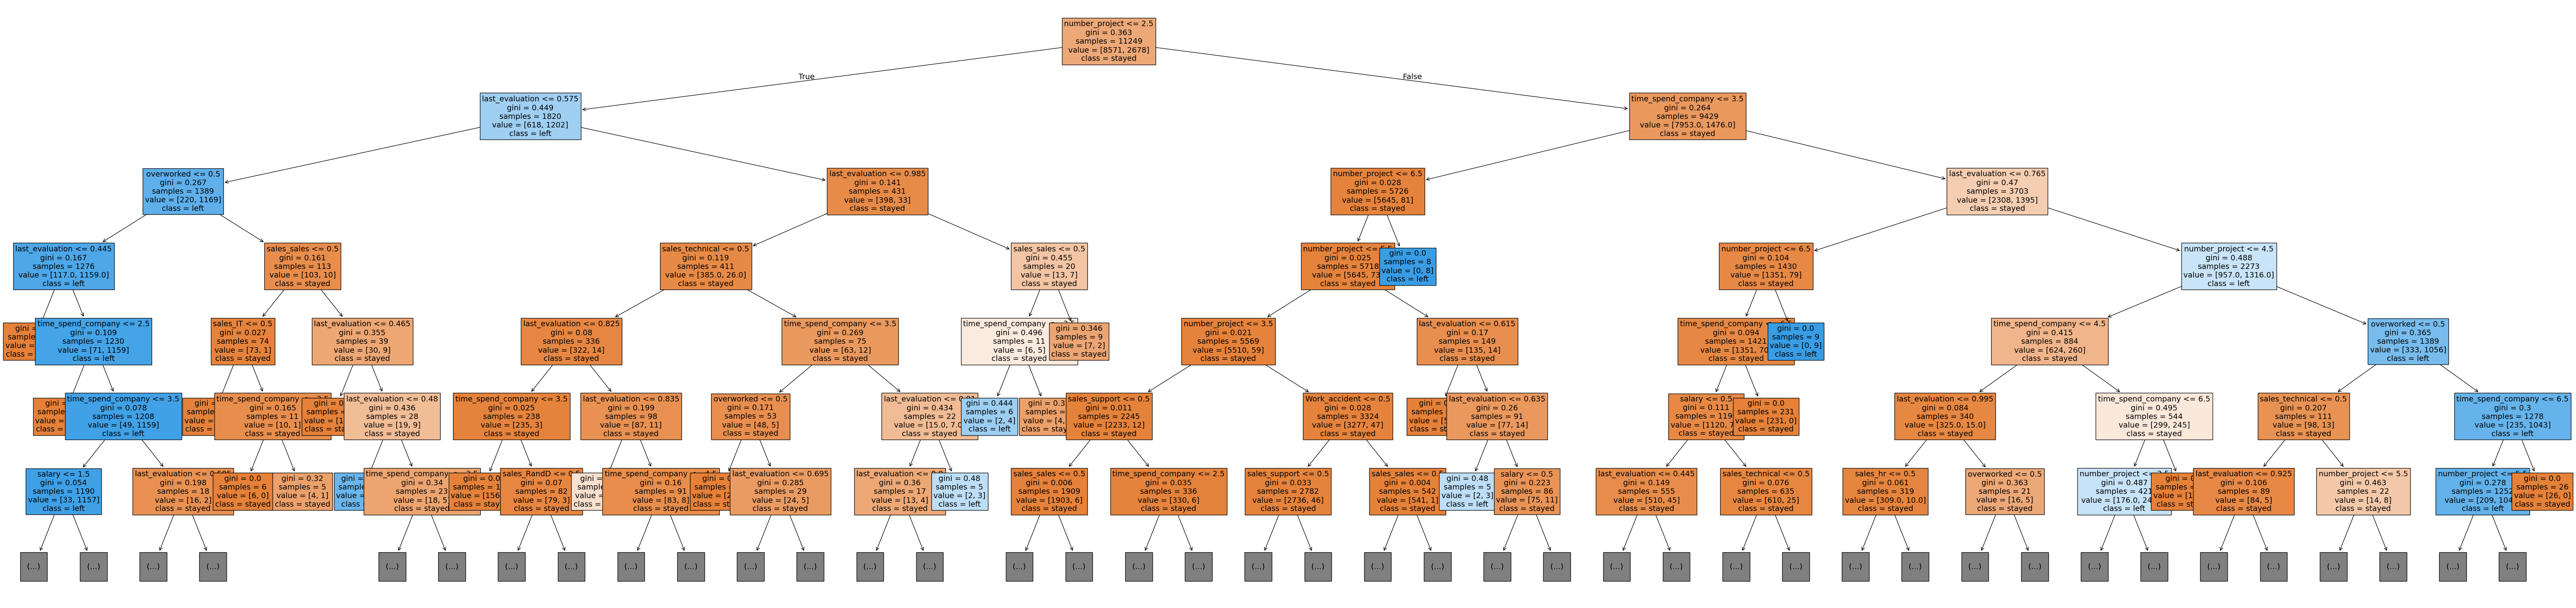

In [129]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [130]:
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

gini_importance
number_project                0.313316
last_evaluation               0.312700
time_spend_company            0.266540
overworked                    0.082346
salary                        0.010098
sales_technical               0.003992
sales_sales                   0.002792
Work_accident                 0.001986
sales_support                 0.001362
promotion_last_5years         0.001345
sales_RandD                   0.000770
sales_IT                      0.000741
sales_accounting              0.000704
sales_hr                      0.000672
sales_product_mng             0.000275
sales_marketing               0.000220
sales_management              0.000140

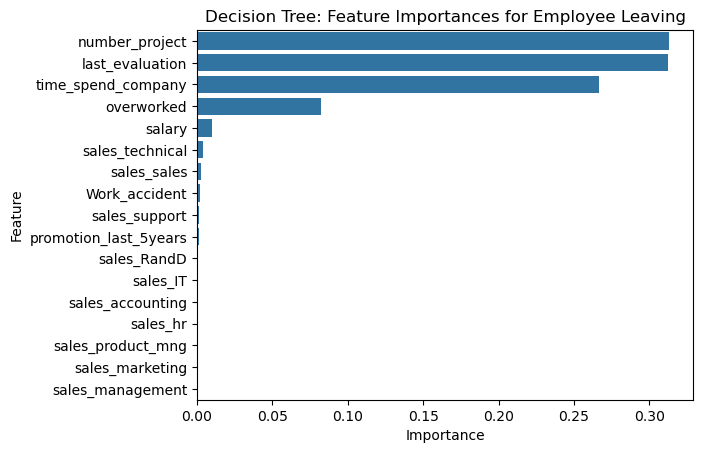

In [131]:
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

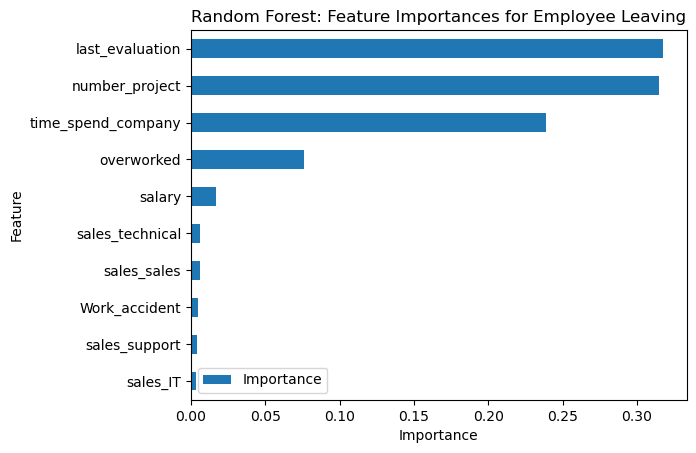

In [132]:
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

In [133]:
print(tree1_cv_results)
print(rf1_cv_results)
print(tree2_cv_results)
print(rf2_cv_results) 

              model  precision    recall        F1  accuracy      auc
0  decision tree cv    0.96232  0.930913  0.946284  0.974842  0.98114
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.990386  0.920834  0.954322   0.97902  0.990797
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv    0.91728  0.891332  0.904003   0.95493  0.970713
               model  precision    recall        F1  accuracy       auc
0  random forest2 cv   0.933895  0.907015  0.920104  0.962486  0.980016


In [134]:
import pandas as pd

# Data for each model's results
results_data = {
    'Model': ['Decision Tree ', 'Random Forest ', 'Decision Tree2 ', 'Random Forest2 '],
    'Precision': [0.96232,0.990386,  0.91728, 0.933895],
    'Recall': [0.930913, 0.920834, 0.891332, 0.907015],
    'F1 Score': [0.946284, 0.954322, 0.904003, 0.920104],
    'Accuracy': [0.974842, 0.97902, 0.95493, 0.962486],
    'AUC': [0.98114, 0.990797, 0.970713, 0.980016]
}

# Create a DataFrame
results_df = pd.DataFrame(results_data)

# Display the DataFrame
print(results_df)

             Model  Precision    Recall  F1 Score  Accuracy       AUC
0   Decision Tree    0.962320  0.930913  0.946284  0.974842  0.981140
1   Random Forest    0.990386  0.920834  0.954322  0.979020  0.990797
2  Decision Tree2    0.917280  0.891332  0.904003  0.954930  0.970713
3  Random Forest2    0.933895  0.907015  0.920104  0.962486  0.980016


In [6]:
with open('EmployeeLeavePredictionhr_rf2.pickle', 'rb') as file:
    model = pickle.load(file)

In [137]:
X_train

last_evaluation  number_project  time_spend_company  Work_accident  \
8943              0.66               4                   2              0   
14247             0.46               2                   3              0   
11511             0.88               5                  10              1   
1221              0.93               5                   5              0   
5768              0.68               2                   3              0   
...                ...             ...                 ...            ...   
12272             0.93               5                   5              0   
7826              0.82               5                   2              1   
9165              0.65               3                   3              0   
9291              0.65               4                   3              0   
9055              0.88               5                   2              1   

       promotion_last_5years  salary  sales_IT  sales_RandD  sales_accounting  \
8943                       0       2     False        False             False   
14247                      0       0     False        False             False   
11511                      0       1     False        False             False   
1221                       0       0     False        False             False   
5768                       0       0     False        False             False   
...                      ...     ...       ...          ...               ...   
12272                      0       1     False        False             False   
7826                       0       1     False        False             False   
9165                       0       0     False        False             False   
9291                       0       0     False        False             False   
9055                       0       0     False        False             False   

       sales_hr  sales_management  sales_marketing  sales_product_mng  \
8943      False             False            False              False   
14247     False             False            False              False   
11511     False             False            False              False   
1221      False             False            False              False   
5768      False             False            False              False   
...         ...               ...              ...                ...   
12272     False             False            False              False   
7826      False             False            False              False   
9165      False             False             True              False   
9291      False             False            False              False   
9055      False             False            False              False   

       sales_sales  sales_support  sales_technical  overworked  
8943          True          False            False           0  
14247        False          False             True           0  
11511        False           True            False           1  
1221          True          False            False           1  
5768         False          False             True           0  
...            ...            ...              ...         ...  
12272        False          False             True           1  
7826         False          False             True           0  
9165         False          False            False           1  
9291         False          False             True           1  
9055         False           True            False           0  

[11249 rows x 17 columns]

In [138]:
y_train

8943     0
14247    1
11511    0
1221     1
5768     0
        ..
12272    1
7826     0
9165     0
9291     0
9055     0
Name: left, Length: 11249, dtype: int64

In [1]:

X_new = [[0.53,2,3,0,0,0,False,False,False,False,False,False,False,True,False,False,0]] 

In [7]:
y_pred_new = model.predict(X_new)

C:\Users\KaruneshChoudhary\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [8]:
print("Predictions for new data:", y_pred_new[0])

Predictions for new data: 1
